# Optical character recognition


## Introduction
Optical character recognition is the electronic conversion of images of typed, handwritten or printed text into machine-encoded text, such as from a scanned document, a photo of a document.

In this tutorial, we will go over how to use forte help us manage/process data related to OCR task. We first need to read image containing text from data source and then process it to obtain text. Therefore, we need a reader and a processor in the pipeline. Plus, we also expect that for each character we can locate a bounding box in the original image. Therefore, we use the ontology `forte.data.ontology.top.Link` that links `forte.data.ontology.top.Annotation` and `forte.data.ontology.top.Box`.

### OCR Reader

It's essentially a reader that reads image from an url, and load the image into `ImagePayload` in the DataPack.

In [50]:
from forte.data.base_reader import PackReader
from ft.onto.base_ontology import ImagePayload
from PIL import Image
import requests
from forte.data.data_pack import DataPack
from typing import Iterator, Any

class OcrReader(PackReader):
    r"""
    :class:`OcrReader` is designed to read an image for an OCR task.
    """
    def _collect(self, image_path) -> Iterator[Any]:  # type: ignore
        r"""
        Should be called with param `image_path` which is the path
        of the image file.

        Args:
            image_path: Image path.

        Returns: Iterator over paths to Image files
        """
        return image_path

    def _parse_pack(self, data_source: str) -> Iterator[DataPack]:
        r"""
        Takes a data source uri and read data from it into :class:`~forte.data.data_pack.DataPack`.

        Args:
            data_source: uri of the image for OCR task.

        Returns: :class:`~forte.data.data_pack.DataPack` containing ImagePayload.
        """
        pack: DataPack = DataPack()
        payload_idx = 0
        
        # Read in Image data and store in DataPack
        # add Image payload into DataPack.payloads
        ip = ImagePayload(pack, payload_idx)
        image_data = Image.open(requests.get(data_source, stream=True).raw)
        ip.set_cache(image_data)
        yield pack

## OCR Processor
It analyzes the image in the DataPack ImagePayload, and predict the bounding box for each character. It wraps predicted bounding boxes and characters in forte ontology and write back into the DataPack.

In [51]:
from forte.data.ontology.top import Box, Link
from ft.onto.base_ontology import Character, Document

from forte.processors.base.pack_processor import PackProcessor
import pytesseract

class OcrProcessor(PackProcessor):
    """
    An audio processor for speaker segmentation.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)

    def _process(self, input_pack: DataPack):
        image_data = input_pack.image_payloads[0].cache
        ocr_text = pytesseract.image_to_string(image_data)
        input_pack.set_text(ocr_text)
        # recognize bounding boxes of text using tesseract
        boxes = pytesseract.image_to_boxes(image_data)
        # boxes are in the format of strings
        # each line of strings represents a configuration of one bounding box
        # each line is in the format of "x0, y0, x1, y1" and the origin is at the bottom-left corner
        boxes = boxes.strip().split("\n")
        begin = 0
        image_height = image_data.height
        for b in boxes:
            b = b.split(" ")
            ch = b[0]
            # pytesseract returns the bounding box whose origin is at the bottom-left
            # so we need to convert the origin to the top-left by using the height of the image and swap y1 and y0
            x0, y1, x1, y0 = int(b[1]), image_height- int(b[2]), int(b[3]), image_height- int(b[4])
            # skip empty text
            while ocr_text[begin].isspace():
                begin += 1
            # for each recognized text, create a box, a character, and a link associating the box and the character
            if ocr_text[begin] == ch:
                character = Character(input_pack, begin, begin+1)
                box = Box(input_pack, [y0, x0], [y1, x1])
                box.set_image_shape(image_data.width, image_data.height)
                Link(input_pack, character, box)
            else:
                raise ValueError(f"text {ocr_text[begin]} != {ch}")
            begin += 1

Let's first take a look at the image we are going to analyze.

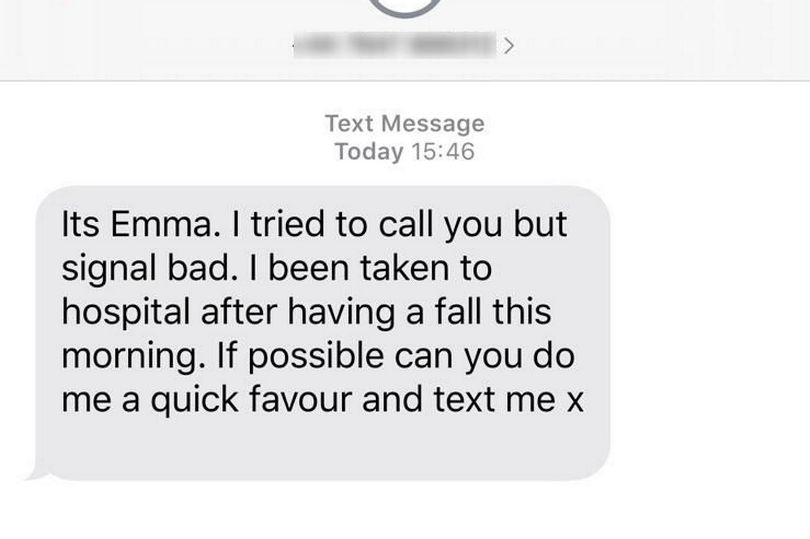

In [52]:
import IPython
image_url = 'https://raw.githubusercontent.com/asyml/forte/assets/ocr_tutorial/ocr.jpg'
IPython.display.Image(image_url, width = 250)

Let's set up a forte pipeline for the OCR task. Plus, we get the processed links which have characters as parents and bounding boxes as children. 

In [53]:
from forte.pipeline import Pipeline
from fortex.nltk import NLTKWordTokenizer

pipeline = Pipeline[DataPack]()
pipeline.set_reader(
    OcrReader()
)
pipeline.add(OcrProcessor())
pipeline.add(NLTKWordTokenizer())
pipeline.initialize()
pack = pipeline.process_one([image_url])


/media/NAS/NLP/Petuum/forte/forte/data/ontology/ontology_code_generator.py:406: UserWarning: No `__init__` function found in the class BoundingBox of the module <module 'forte.data.ontology.top' from '/media/NAS/NLP/Petuum/forte/forte/data/ontology/top.py'>.
  f"No `__init__` function found in the class"


In [54]:
from PIL import Image, ImageDraw


links = pack.get(Link)


User can repetitively run this code cell (before the box iterator ends) below to recognize the next character

In [76]:
first_link = next(links)
ch = first_link.get_parent()
ch_bb= first_link.get_child() 
image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)
d.rectangle([(ch_bb.box_min_x, ch_bb.box_min_y), (ch_bb.box_max_x, ch_bb.box_max_y)], outline = "#ff0000")
print("Recognized character: ", ch.text)
print(f"Recognized Bounding Box surrounding {ch.text}")
image_data

StopIteration: 

User to can run the code cell below to recognize the bounding boxes for the rest characters

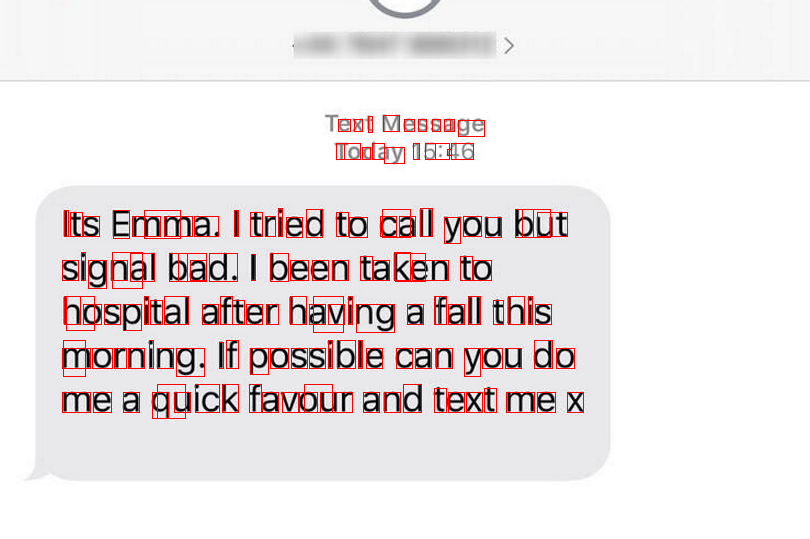

In [56]:
image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)

for link in links:
    ch = link.get_parent()
    ch_bb = link.get_child() 
    d.rectangle([(ch_bb.box_min_x, ch_bb.box_min_y), (ch_bb.box_max_x, ch_bb.box_max_y)], outline = "#ff0000")
image_data

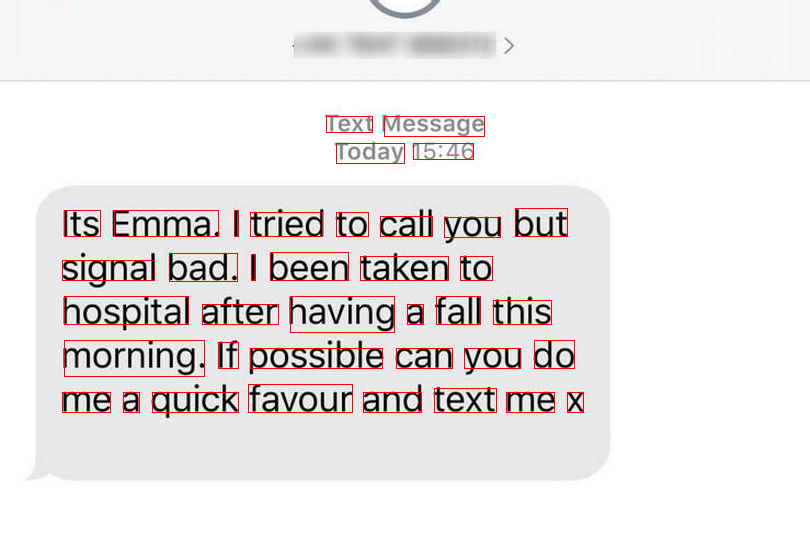

In [75]:
from ft.onto.base_ontology import Token
image_data = Image.open(requests.get(image_url, stream=True).raw)
d = ImageDraw.Draw(image_data)
for token in pack.get(Token):
    if len(token.text) >= 1:
        charcters = list(token.get(Character))
        # obtain the bounding box of the first and last character of a token
        # so that we can locate the bounding box for the token
        first_ch_link = pack.get_links_by_parent(charcters[0])[0]
        last_ch_link =  pack.get_links_by_parent(charcters[-1])[0]
        first_ch_bb = first_ch_link.get_child() 
        last_ch_bb = last_ch_link.get_child()
        top_left = [first_ch_bb.box_min_y, first_ch_bb.box_min_x]
        bottom_right = [last_ch_bb.box_max_y, last_ch_bb.box_max_x]
        # similar to adding characters in OCRProcessor
        # we add token bounding box, token and their link to the data pack
        token_box = Box(pack, top_left, bottom_right)
        token_box.set_image_shape(image_data.width, image_data.height)
        Link(pack, token, token_box)
        # Visuliaze the bounding box (image with a box around it).
        d.rectangle([(token_box.box_min_x, token_box.box_min_y), (token_box.box_max_x, token_box.box_max_y)], outline = "#ff0000")

image_data